### Setup

In [ ]:
# %%capture --no-stderr
# %pip install -U langgraph langchain_community langchain_openai langchain_experimental pyppeteer

In [ ]:
import os
import subprocess
import stat
import re
import json
from pathlib import Path
import yaml

from typing import Annotated, Literal, List
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END
from langchain.agents import AgentExecutor
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

import getpass

from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter, CharacterTextSplitter

from langchain.tools.retriever import create_retriever_tool

from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing import Annotated
from langgraph.graph.message import add_messages

from langgraph.graph import MessagesState

from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
import nest_asyncio


In [ ]:
SOC_BASE_DIR = "/home/XXXX-2/hackdate"

## VC Lint tool that checks a design for lint checks

In [ ]:
def gen_opentitan_filelist(p,m):

    # print(p)
    # if fusesoc.conf file exists, delete it
    if(os.path.exists("fusesoc.conf")):
        os.remove("fusesoc.conf")
    # if build directory exists, delete it
    # if(os.path.exists("build")):
    #     cmd = "rm -rf build"
    #     subprocess.run(cmd.split(' '))

    # add opentitan libray of cores to fusesoc
    cmd = f"fusesoc library add opentitan-cores {SOC_BASE_DIR}/hw"
    subprocess.run(cmd.split(' '))
    # print(cmd)

    # directory containing the core file
    p_str = str(p)
    core_dir = p_str[:p_str.find('/rtl/')]
    # core_dir = Path('opentitan').joinpath(p.parent).parent # assuming file is in rtl/buggyfile.sv
    # print("core dir: "+str(core_dir))

    # get the core files in core 
    core_files  = []
    for file in os.listdir(core_dir):
        if file.endswith(".core"):
            # print(os.path.join(core_dir, file))
            core_files.append(os.path.join(core_dir, file))
    # print("core files:\n"+str(core_files))
    # identify the correct core file by traversing using yaml parser and get the identifier for the core
    flags = set()
    if('/ip/' in p_str):
        flags.add('fileset_ip')
    identifier_core = ''
    relevant_core_file=''
    found=False
    for core_file in core_files:
        if(not os.path.exists(core_file) ):
            return ''
        with open(core_file,'r') as f:
            core_yaml = yaml.safe_load(f)
            files = core_yaml["filesets"]["files_rtl"]["files"]
            for file in files:
                if (m in file): # this is the right core file
                    identifier_core = core_yaml["name"] # get the identifier for the core
                    found=True
                    break
            if(found):
                for file in files: # get flags
                    # check if there is a flag
                    # get that flag
                    # update flag ommand string
                    if ("?" in file):
                        flag = file[:file.find('?')]
                        flag=flag.replace("\"","")
                        flag=flag.replace(" ","")
                        flags.add(flag)
        if (found):
            relevant_core_file = core_file
            break

    # print("relevant_core_file: "+relevant_core_file)
    # print("identifier_core: "+identifier_core)
    
    # run the fusesoc run setup command
    flag_command = ''
    for flag in flags:
        flag_command = flag_command + "--flag "+flag+" "
    # make sure top level exists
    if (not 'toplevel' in core_yaml["targets"]["default"]):
        # create toplevel
        core_yaml["targets"]["default"]["toplevel"]= m
        # write core_yaml to relevant corefile
        if(not os.path.exists(relevant_core_file) ):
            return ''
        with open(relevant_core_file, 'w',) as f :
            yaml.dump(core_yaml,f,sort_keys=False)
    elif(core_yaml["targets"]["default"]["toplevel"]==''):
        core_yaml["targets"]["default"]["toplevel"]= m
        if(not os.path.exists(relevant_core_file) ):
            return ''
        with open(relevant_core_file, 'w',) as f :
            yaml.dump(core_yaml,f,sort_keys=False)

    cmd = "fusesoc run --setup --tool=vcs "+flag_command+identifier_core
    subprocess.run(cmd.split(' '))
#     log.write(cmd+'\n')
#     log.flush()

    # extract the path of .scr file
    scr_filepath = Path('build').joinpath(identifier_core.replace(':','_'),'default-vcs',identifier_core.replace(':','_')+'.scr')
    print(scr_filepath)

    return str(scr_filepath)


In [ ]:
@tool
def lint_checker_tool(design_filepath: str, top_module: str, lint_tags: List[str]):
    
    """Use this tool to execute VC SpyGlass Lint lint_checks on the top_module.
    It takes the path to a verilog file, the top module name, and a list of lint tags to check."""
    result = ""
    try:
        # get all relevant files
        scr_filepath = gen_opentitan_filelist(design_filepath,top_module)
        src_files = open(scr_filepath,'r').read()    
        src_files = src_files.replace('../',scr_filepath[:scr_filepath.find('default-vcs/')])   
        fw = open('filelist_'+top_module+'.txt','w')
        fw.write(src_files)
        fw.close()
        
        # form tcl script for vc_static

        tcl_template_file = 'vcst_template.tcl' 
        tcl_template_content = open(tcl_template_file,'r').read()

        lint_checks = '\n'.join([ 'configure_lint_tag -enable -tag \"' + tag + '\" -severity Error' for tag in lint_tags ])
        tcl_template_content = tcl_template_content.replace('[LINT_TAGS]',lint_checks)

        tcl_template_content = tcl_template_content.replace('[TOP_MODULE]',top_module)
        tcl_template_content = tcl_template_content.replace('[FILELIST]','filelist_'+top_module+'.txt')
        results_file = 'results_vcst_'+top_module+'.txt'
        tcl_template_content = tcl_template_content.replace('[RESULT_FILE]',results_file)

        tcl_script = 'vcst_'+top_module+'.tcl'
        wf = open(tcl_script,'w')
        wf.write(tcl_template_content)
        wf.close()
        
        # run tcl script
        wf = open('run_vcst.sh','w')
        cmd = "vc_static_shell -batch -no_ui -f "+ tcl_script
        wf.write(cmd)
        wf.close()

        os.chmod('run_vcst.sh',stat.S_IRWXU)
        subprocess.run('./run_vcst.sh',shell=True, capture_output=True, text=True)
        
        result = open(results_file,'r').read()
        
    except BaseException as e:
        # print stack trace
        import traceback
        traceback.print_exc()
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n```lint checker tool\n```\nOutput: {result}"
    
    return result_str

In [ ]:
#lint_checker_tool(f'{SOC_BASE_DIR}/hw/ip/adc_ctrl/rtl/adc_ctrl_fsm.sv','adc_ctrl_fsm',['LINT_FSM_UNREACHABLE_STATES'])

## Run Verilator Tests


In [ ]:
# Run bazel query and get list of tests
def get_verilator_tests(ip: str) -> str:

    # get the list of tests
    cmd = [f"{SOC_BASE_DIR}/bazelisk.sh", "query","tests(//sw/...) except attr(tags, cw310, tests(//...))  except attr(tags, cw340, tests(//...)) except attr(tags, dv, tests(//...))"]
    result = subprocess.run(cmd, capture_output=True, text=True, cwd=SOC_BASE_DIR)
    if(result.returncode != 0):
        print("Error running command")
        print(" ".join(cmd))
        return []
    tests = result.stdout.split('\n')
    tests = [test for test in tests if test != '' and ip in test and "rom_ext" not in test]
    return tests

#test 
tests = get_verilator_tests('aes')
print(tests)

In [ ]:
# @tool
def run_verilator_tests(ip):
    """Use this tool to execute verilator tests for the given ip.
       Returns a list of executed tests and their status."""
    # get the list of tests
    tests = get_verilator_tests(ip)
    print(tests)
    if(len(tests) == 0):
        return "No verilator tests found for this IP."
    # run the tests
    cmd = [f"{SOC_BASE_DIR}/bazelisk.sh", "test",  "--test_timeout=320"]
    cmd += tests
    print(" ".join(cmd))
    result = subprocess.run(cmd, stdout=subprocess.PIPE,stderr=subprocess.STDOUT, text=True, cwd=SOC_BASE_DIR)
    
    return result.stdout.split("INFO:")[-1]


# result = run_verilator_tests('aes')
# print(result.stdout)

In [ ]:
# print(result.stdout.split("INFO:")[-1])

## Similar bug search

In [ ]:
@tool
def read_file_with_line_numbers(file_path: str) -> str:
    """Reads a file and returns its content with line numbers."""
    print(f"Reading file with line numbers: {file_path}")
    with open(file_path, 'r') as file:
        lines = file.readlines()
    numbered_lines = [f"{i + 1}: {line}" for i, line in enumerate(lines)]
    return "".join(numbered_lines)

In [ ]:
# # test
# file = '/home/XXXX-2/hack_date_finals/hackdate/hw/ip/adc_ctrl/rtl/adc_ctrl_fsm.sv'
# file_content = read_file_with_line_numbers(file)

# # print first 20 lines
# print(file_content)

In [ ]:
@tool
def similar_bug_tool(bug:str, ip_file: str) -> str:
    """ Use this tool to look for bugs similar to previously found bugs. 
        Pass bug line and a file path to search for similar bugs.
        Returns a list of similar bug lines with line numbers.
    """
    # check if file exists
    if(not os.path.exists(ip_file)):
        return "File does not exist."
    
    # read ip_file
    with open(ip_file, 'r') as f:
        ip_file_content = f.read()
    ip_lines = ip_file_content.split('\n')
    # strip all lines in ip_lines
    ip_lines = [line.strip() for line in ip_lines]

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        separators=['\n'],
        chunk_size=30,
        chunk_overlap=0,
    )
    documents = [Document(page_content=open(ip_file,'r').read()) ]
    doc_splits = text_splitter.split_documents(documents)
    # Add to vectorDB
    vectorstore = InMemoryVectorStore.from_documents(
        documents=doc_splits,
        collection_name="lint_tags",
        embedding=OpenAIEmbeddings(),
    )
    # Create retriever
    retriever = vectorstore.as_retriever(search_kwargs={"k": 10})
    result = retriever.invoke(bug)

    # for each result find line number and build response
    response = ""
    for r in result:
        # get the line number
        line_number = ip_lines.index(r.page_content.strip()) + 1
        # add to result
        response += f"\nFound similar bug in {ip_file} at line {line_number}: {r.page_content}"
    return response


In [ ]:
# # test 

# bug ="""DIP_CLEAR:   data_in_prev_d = data_in;
# """
# file = "/home/XXXX-2/hack_date_finals/hackdate/hw/ip/aes/rtl/aes_cipher_core.sv"

# result = similar_bug_tool(bug, file)
# print(result)

## VC Formal tool that checks a design for assertions

In [14]:
@tool
def assertion_checker_tool(design_filepath, top_module, assertions, clock_signal, reset_signal, reset_active):
    
    """Use this tool to execute VC Formal assertions on the top_module."""
    result = ""
    try:
        # get all relevant files
        scr_filepath = gen_opentitan_filelist(design_filepath,top_module)
        src_files = open(scr_filepath,'r').read()    
        src_files = src_files.replace('../',scr_filepath[:scr_filepath.find('default-vcs/')])   
        filelist = 'filelist_'+top_module+'.txt'
        fw = open(filelist,'w')
        fw.write(src_files)
        fw.close()
        
        # form tcl script for vc_formal

        tcl_template_file = 'vcf_template.tcl' 
        tcl_template_content = open(tcl_template_file,'r').read()

        tcl_template_content = tcl_template_content.replace('[TOP_MODULE]',top_module)
        tcl_template_content = tcl_template_content.replace('[FILELIST]',filelist)
        tcl_template_content = tcl_template_content.replace('[CLK]',clock_signal)
        tcl_template_content = tcl_template_content.replace('[RST]',reset_signal)
        tcl_template_content = tcl_template_content.replace('[RST_ACTIVE]',reset_active)
        
        results_file = 'results_vcf_'+top_module+'.txt'
        tcl_template_content = tcl_template_content.replace('[RESULT_FILE]',results_file)

        tcl_script = 'vcf_'+top_module+'.tcl'
        wf = open(tcl_script,'w')
        wf.write(tcl_template_content)
        wf.close()
        
        
        # insert assertions to source RTL
        assertions_str = '\n\n'.join(assertions)
        design_content = open(design_filepath,'r').read()
        design_content = design_content.replace("endmodule","\n"+assertions_str+"\n\nendmodule")
        # save the edited design RTL as a copy <design>_assertion-inserted.sv
        design_basename = os.path.basename(design_filepath)
        design_basename, extension = design_basename.split('.')
        assertion_inserted_filename = design_filepath[:design_filepath.find(design_basename)] + design_basename + '_assertion-inserted.'+extension
        wf = open(assertion_inserted_filename,'w')
        wf.write(design_content)
        wf.close()
            
        # change the source filename in filelist
        filelist_content = open(filelist,'r').read()
        filelist_content = re.sub(r'.*'+top_module+'.'+extension,assertion_inserted_filename,filelist_content)
        fw = open(filelist,'w')
        fw.write(filelist_content)
        fw.close()
        
        # run tcl script
        wf = open('run_vcf.sh','w')
        cmd = "vcf -batch -no_ui -f "+ tcl_script
        wf.write(cmd)
        wf.close()

        os.chmod('run_vcf.sh',stat.S_IRWXU)
        subprocess.run('./run_vcf.sh',shell=True, capture_output=True, text=True)
        
        result = open(results_file,'r').read()
        
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n```assertion checker tool\n```\nOutput: {result}"
    
    return result_str

In [15]:
assertion1 = """
property p1;
    @(posedge clk_i) addr_hit[8] & reg_we & !reg_error |-> wipe_secret_we;  
endproperty

ap1: assert property (p1);
"""

assertions = [assertion1]
#assertion_checker_tool('hack_date_2025/opentitan_phase1/opentitan_buggy/hw/ip/hmac/rtl/hmac_reg_top.sv',\
#                       'hmac_reg_top', assertions, 'clk_i', 'rst_ni', 'low')

In [16]:
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")

In [17]:
# To display graphs

def display_graph(graph):
    nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

    display(
        Image(
            graph.get_graph().draw_mermaid_png(
                curve_style=CurveStyle.LINEAR,
                node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
                wrap_label_n_words=9,
                output_file_path=None,
                draw_method=MermaidDrawMethod.PYPPETEER,
                background_color="white",
                padding=10,
            )
        )
    )

## Linter Agent

### RAG retriever to get lint tags

In [18]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = InMemoryVectorStore(embeddings)

In [19]:
lint_tags_description_filename = 'all_lint_tags_descriptions.txt'
documents = [Document(page_content=open(lint_tags_description_filename,'r').read()) ]

In [20]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    separators=['\n'],
    chunk_size=15,
    chunk_overlap=0,
)
doc_splits = text_splitter.split_documents(documents)

In [21]:
len(doc_splits)

1254

In [22]:
# Add to vectorDB
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    collection_name="lint_tags",
    embedding=OpenAIEmbeddings(),
)

In [23]:
lint_tag_retriever = vectorstore.as_retriever(search_kwargs={"k": 20})

In [24]:
output = lint_tag_retriever.invoke("What are the Lint tags relevant to FSMs?")

In [25]:
for o in output:
    print(o.page_content.split(':')[0], '\n')


LINT_FSM_WITHOUT_INITIAL_STATE 

FsmUsage-ML 


LINT_FSM_WITHOUT_EXIT_STATE 


LINT_FSM_UNREACHABLE_STATES 


LINT_INTERACTING_FSM 


NoExitInFSM-ML 


FSMNextStateName-ML 

FsmLiveLock 


STARC05-2.11.1.4 


FSMCurrentStateName-ML 


MissingFsmStateTransition 


AsgnNextSt-ML 


STARC05-2.11.2.1 


STARC05-2.4.1.4 


SepFSMLogic 


STARC05-2.11.1.2 


GlitchGenCircuitCheck 


STARC05-2.11.3.1 


STARC05-1.4.3.6 


STARC05-1.6.1.2 



### Agent utilizing the retriever and lint checker as tools

In [26]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

lint_tag_retriever_tool = create_retriever_tool(
    lint_tag_retriever,
    "retrieve_relevant_lint_tags",
    "Search and return relevant lint tags pertaining to the security issue being analyzed.",
)

linter_tools = [lint_tag_retriever_tool, lint_checker_tool]

llm_lint_checker = llm.bind_tools(linter_tools, parallel_tool_calls=False)

### Graph for workflow of lint checker agent

In [27]:
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

# Nodes of graph
sys_msg_lint_checker_agent = SystemMessage(content="You are a helpful assistant tasked with testing RTL code for security issues using lint checks.")
def lint_checker_agent(state: MessagesState):
    return {"messages": [llm_lint_checker.invoke([sys_msg_lint_checker_agent] + state["messages"])]}

def lint_tools_condition(state) -> Literal["linter_tools", "END"]:
    
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:

        return "linter_tools"
    
    return "END"

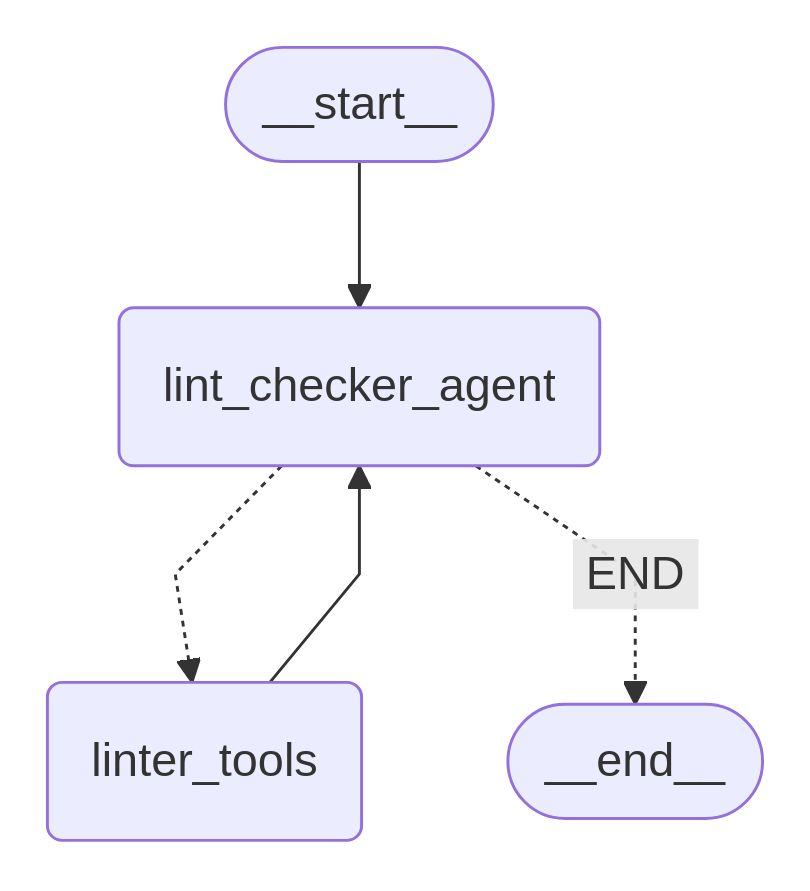

In [28]:
# Graph
# builder = None
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("lint_checker_agent", lint_checker_agent)
builder.add_node("linter_tools", ToolNode(linter_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "lint_checker_agent")
builder.add_conditional_edges(
    "lint_checker_agent",
#     If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
#     If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    lint_tools_condition,
    {"linter_tools":"linter_tools", "END":END},
)
builder.add_edge("linter_tools", "lint_checker_agent")

# builder.add_edge("lint_checker_agent", END)

# graph = None
lint_graph = builder.compile()

# Show
display_graph(lint_graph)

In [29]:
design_filepath = f'{SOC_BASE_DIR}/hw/ip/adc_ctrl/rtl/adc_ctrl_fsm.sv'
top_module = 'adc_ctrl_fsm'
rtl_file_content = open(design_filepath,'r').read()
instruction =\
f"""Are there FSM related security concerns with the provided RTL:

\"\"\"

{rtl_file_content}

\"\"\"

The design filepath is:

{design_filepath}

And the top module is:

{top_module}

Identify relevant lint tags for the RTL to be checked for.
Then run the tests using the linting tool.
From the output of the linting tool, determine if there are security issues in the RTL.
"""

In [30]:
print(instruction)

Are there FSM related security concerns with the provided RTL:

"""

// Copyright lowRISC contributors (OpenTitan project).
// Licensed under the Apache License, Version 2.0, see LICENSE for details.
// SPDX-License-Identifier: Apache-2.0
//
// Description adc_ctrl detection FSM module

module adc_ctrl_fsm
  import adc_ctrl_reg_pkg::*;
  import adc_ctrl_pkg::*;
(
  input clk_aon_i,
  input rst_aon_ni,
  input cfg_fsm_rst_i,
  input cfg_adc_enable_i,
  input cfg_oneshot_mode_i,
  input cfg_lp_mode_i,
  input [3:0] cfg_pwrup_time_i,
  input [23:0] cfg_wakeup_time_i,
  input [7:0]  cfg_lp_sample_cnt_i,
  input [15:0] cfg_np_sample_cnt_i,
  input [NumAdcFilter-1:0] adc_ctrl_match_i,
  input [9:0] adc_d_i,
  input       adc_d_val_i,//valid bit for ADC value
  output logic      adc_pd_o,
  output logic[1:0] adc_chn_sel_o,
  output logic      chn0_val_we_o,
  output logic      chn1_val_we_o,
  output logic [9:0] chn0_val_o,
  output logic [9:0] chn1_val_o,
  output logic       adc_ctrl_done_o

In [31]:
message = [HumanMessage(content=instruction)]
result = lint_graph.invoke({"messages": message})

INFO: Interpreting sync-uri '/home/XXXX-2/hackdate/hw' as location for local provider.
INFO: Preparing lowrisc:constants:top_pkg:0
INFO: Preparing lowrisc:dv:dv_macros:0
INFO: Preparing lowrisc:dv:pins_if:0
INFO: Preparing lowrisc:prim:assert:0.1
INFO: Preparing lowrisc:prim:cipher_pkg:0.1
INFO: Preparing lowrisc:prim:pad_wrapper_pkg:0
INFO: Preparing lowrisc:prim:primgen:0.1
INFO: Preparing lowrisc:prim:secded:0.1
INFO: Preparing lowrisc:prim:sha2_pkg:0
INFO: Preparing lowrisc:prim:arbiter:0
INFO: Preparing lowrisc:prim:cdc_rand_delay:0
INFO: Preparing lowrisc:prim:cipher:0
INFO: Preparing lowrisc:prim:count:0
INFO: Preparing lowrisc:prim:prim_pkg:0.1
INFO: Preparing lowrisc:prim:sec_anchor:0.1
INFO: Preparing lowrisc:prim:sha2:0
INFO: Preparing lowrisc:prim:sparse_fsm:0
INFO: Preparing lowrisc:prim:util:0.1
INFO: Preparing lowrisc:ip:lc_ctrl_state_pkg:0.1
INFO: Preparing lowrisc:prim:and2:0
INFO: Preparing lowrisc:prim:buf:0
INFO: Preparing lowrisc:prim:clock_inv:0
INFO: Preparing lo

Creating prim_pkg.sv
Core file written to prim_pkg.core.


INFO: Generating lowrisc:prim:and2-impl:0


Implementations for primitive and2: xilinx, generic, xilinx_ultrascale
Inspecting generic module /home/XXXX-2/hackdate/hw/ip/prim_generic/rtl/prim_generic_and2.sv
[Errno 2] No such file or directory: 'verible-verilog-syntax'
Verible parser failed, using regex fallback instead.
Creating SystemVerilog module for abstract primitive
Abstract primitive written to /tmp/lowrisc_prim_and2-impl_0a80s98_g/prim_and2.sv
Creating core file for primitive and2.
Core file written to /tmp/lowrisc_prim_and2-impl_0a80s98_g/prim_and2.core


INFO: Generating lowrisc:prim:buf-impl:0


Implementations for primitive buf: generic, xilinx_ultrascale, xilinx
Inspecting generic module /home/XXXX-2/hackdate/hw/ip/prim_generic/rtl/prim_generic_buf.sv
[Errno 2] No such file or directory: 'verible-verilog-syntax'
Verible parser failed, using regex fallback instead.
Creating SystemVerilog module for abstract primitive
Abstract primitive written to /tmp/lowrisc_prim_buf-impl_0vr4ol9on/prim_buf.sv
Creating core file for primitive buf.
Core file written to /tmp/lowrisc_prim_buf-impl_0vr4ol9on/prim_buf.core


INFO: Generating lowrisc:prim:clock_inv-impl:0


Implementations for primitive clock_inv: xilinx_ultrascale, generic
Inspecting generic module /home/XXXX-2/hackdate/hw/ip/prim_generic/rtl/prim_generic_clock_inv.sv
[Errno 2] No such file or directory: 'verible-verilog-syntax'
Verible parser failed, using regex fallback instead.
Creating SystemVerilog module for abstract primitive
Abstract primitive written to /tmp/lowrisc_prim_clock_inv-impl_01jvdhtc5/prim_clock_inv.sv
Creating core file for primitive clock_inv.
Core file written to /tmp/lowrisc_prim_clock_inv-impl_01jvdhtc5/prim_clock_inv.core


INFO: Generating lowrisc:prim:clock_mux2-impl:0


Implementations for primitive clock_mux2: xilinx, generic, xilinx_ultrascale
Inspecting generic module /home/XXXX-2/hackdate/hw/ip/prim_generic/rtl/prim_generic_clock_mux2.sv
[Errno 2] No such file or directory: 'verible-verilog-syntax'
Verible parser failed, using regex fallback instead.
Creating SystemVerilog module for abstract primitive
Abstract primitive written to /tmp/lowrisc_prim_clock_mux2-impl_0pxqbw_qk/prim_clock_mux2.sv
Creating core file for primitive clock_mux2.
Core file written to /tmp/lowrisc_prim_clock_mux2-impl_0pxqbw_qk/prim_clock_mux2.core


INFO: Generating lowrisc:prim:flop-impl:0


Implementations for primitive flop: generic, xilinx_ultrascale, xilinx
Inspecting generic module /home/XXXX-2/hackdate/hw/ip/prim_generic/rtl/prim_generic_flop.sv
[Errno 2] No such file or directory: 'verible-verilog-syntax'
Verible parser failed, using regex fallback instead.
Creating SystemVerilog module for abstract primitive
Abstract primitive written to /tmp/lowrisc_prim_flop-impl_0o75bf1xu/prim_flop.sv
Creating core file for primitive flop.
Core file written to /tmp/lowrisc_prim_flop-impl_0o75bf1xu/prim_flop.core


INFO: Generating lowrisc:prim:flop_2sync-impl:0


Implementations for primitive flop_2sync: generic
Inspecting generic module /home/XXXX-2/hackdate/hw/ip/prim_generic/rtl/prim_generic_flop_2sync.sv
[Errno 2] No such file or directory: 'verible-verilog-syntax'
Verible parser failed, using regex fallback instead.
Creating SystemVerilog module for abstract primitive
Abstract primitive written to /tmp/lowrisc_prim_flop_2sync-impl_0p_4bvte7/prim_flop_2sync.sv
Creating core file for primitive flop_2sync.
Core file written to /tmp/lowrisc_prim_flop_2sync-impl_0p_4bvte7/prim_flop_2sync.core


INFO: Generating lowrisc:prim:flop_en-impl:0


Implementations for primitive flop_en: xilinx, generic, xilinx_ultrascale
Inspecting generic module /home/XXXX-2/hackdate/hw/ip/prim_generic/rtl/prim_generic_flop_en.sv
[Errno 2] No such file or directory: 'verible-verilog-syntax'
Verible parser failed, using regex fallback instead.
Creating SystemVerilog module for abstract primitive
Abstract primitive written to /tmp/lowrisc_prim_flop_en-impl_05nugc34_/prim_flop_en.sv
Creating core file for primitive flop_en.
Core file written to /tmp/lowrisc_prim_flop_en-impl_05nugc34_/prim_flop_en.core


INFO: Generating lowrisc:prim:pad_wrapper-impl:0


Implementations for primitive pad_wrapper: xilinx_ultrascale, xilinx, generic
Inspecting generic module /home/XXXX-2/hackdate/hw/ip/prim_generic/rtl/prim_generic_pad_wrapper.sv
[Errno 2] No such file or directory: 'verible-verilog-syntax'
Verible parser failed, using regex fallback instead.
Creating SystemVerilog module for abstract primitive
Abstract primitive written to /tmp/lowrisc_prim_pad_wrapper-impl_0yhdqm235/prim_pad_wrapper.sv
Creating core file for primitive pad_wrapper.
Core file written to /tmp/lowrisc_prim_pad_wrapper-impl_0yhdqm235/prim_pad_wrapper.core


INFO: Generating lowrisc:prim:xnor2-impl:0


Implementations for primitive xnor2: generic
Inspecting generic module /home/XXXX-2/hackdate/hw/ip/prim_generic/rtl/prim_generic_xnor2.sv
[Errno 2] No such file or directory: 'verible-verilog-syntax'
Verible parser failed, using regex fallback instead.
Creating SystemVerilog module for abstract primitive
Abstract primitive written to /tmp/lowrisc_prim_xnor2-impl_02hnil0n_/prim_xnor2.sv
Creating core file for primitive xnor2.
Core file written to /tmp/lowrisc_prim_xnor2-impl_02hnil0n_/prim_xnor2.core


INFO: Generating lowrisc:prim:xor2-impl:0


Implementations for primitive xor2: xilinx_ultrascale, xilinx, generic
Inspecting generic module /home/XXXX-2/hackdate/hw/ip/prim_generic/rtl/prim_generic_xor2.sv
[Errno 2] No such file or directory: 'verible-verilog-syntax'
Verible parser failed, using regex fallback instead.
Creating SystemVerilog module for abstract primitive
Abstract primitive written to /tmp/lowrisc_prim_xor2-impl_094ns9vtq/prim_xor2.sv
Creating core file for primitive xor2.
Core file written to /tmp/lowrisc_prim_xor2-impl_094ns9vtq/prim_xor2.core


INFO: Wrote dependency graph to /home/XXXX-2/security_agents/build/lowrisc_ip_adc_ctrl_1.0/default-vcs/lowrisc_ip_adc_ctrl_1.0.deps-after-generators.dot
INFO: Setting up project



build/lowrisc_ip_adc_ctrl_1.0/default-vcs/lowrisc_ip_adc_ctrl_1.0.scr


In [36]:
for m in result['messages']:
    print(m.pretty_repr())


================================ Human Message =================================

Are there FSM related security concerns with the provided RTL:

"""

// Copyright lowRISC contributors (OpenTitan project).
// Licensed under the Apache License, Version 2.0, see LICENSE for details.
// SPDX-License-Identifier: Apache-2.0
//
// Description adc_ctrl detection FSM module

module adc_ctrl_fsm
  import adc_ctrl_reg_pkg::*;
  import adc_ctrl_pkg::*;
(
  input clk_aon_i,
  input rst_aon_ni,
  input cfg_fsm_rst_i,
  input cfg_adc_enable_i,
  input cfg_oneshot_mode_i,
  input cfg_lp_mode_i,
  input [3:0] cfg_pwrup_time_i,
  input [23:0] cfg_wakeup_time_i,
  input [7:0]  cfg_lp_sample_cnt_i,
  input [15:0] cfg_np_sample_cnt_i,
  input [NumAdcFilter-1:0] adc_ctrl_match_i,
  input [9:0] adc_d_i,
  input       adc_d_val_i,//valid bit for ADC value
  output logic      adc_pd_o,
  output logic[1:0] adc_chn_sel_o,
  output logic      chn0_val_we_o,
  output logic      chn1_val_we_o,
  output logic [9:0]

# Verilator Agent

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

verilator_tools = [run_verilator_tests]

llm_verilator_checker = llm.bind_tools(verilator_tools, parallel_tool_calls=False)

In [ ]:
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

# Nodes of graph
sys_msg_verilator_agent = SystemMessage(content="You are a helpful assistant tasked with testing RTL code for security issues using Verilator simulations for existing testing infrastructutre.")
def verilator_agent(state: MessagesState):
    return {"messages": [llm_verilator_checker.invoke([sys_msg_verilator_agent] + state["messages"])]}

def verilator_tools_condition(state) -> Literal["verilator_tools", "END"]:
    
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:

        return "verilator_tools"
    
    return "END"


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("verilator_agent", verilator_agent)
builder.add_node("verilator_tools", ToolNode(verilator_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "verilator_agent")
builder.add_conditional_edges(
    "verilator_agent",
#     If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
#     If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    verilator_tools_condition,
    {"verilator_tools":"verilator_tools", "END":END},
)
builder.add_edge("verilator_tools", "verilator_agent")

# builder.add_edge("lint_checker_agent", END)

# graph = None
verilator_graph = builder.compile()



In [ ]:
# Show
display_graph(verilator_graph)

## Similar Bug Agent

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

similar_bug_tools = [similar_bug_tool, read_file_with_line_numbers]

llm_similar_bug = llm.bind_tools(similar_bug_tools, parallel_tool_calls=False)

In [ ]:
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

# Nodes of graph
sys_msg_similar_bug_agent = SystemMessage(content="""You are a helpful assistant tasked with identify bug instances similar to given bugs in the provided RTL code. 
Identify lines with similar code by providing the full bug line to the tool.
Multiple identified lines might not be actual bugs.
Analyze the identified lines and determine if they are indeed bugs.
Only reply with a list of buggy lines with line numbers.""")

def similar_bug_agent(state: MessagesState):
    return {"messages": [llm_similar_bug.invoke([sys_msg_similar_bug_agent] + state["messages"])]}

def similar_bug_tools_condition(state) -> Literal["similar_bug_tools", "END"]:
    
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:

        return "similar_bug_tools"
    
    return "END"


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("similar_bug_agent", similar_bug_agent)
builder.add_node("similar_bug_tools", ToolNode(similar_bug_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "similar_bug_agent")
builder.add_conditional_edges(
    "similar_bug_agent",
#     If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
#     If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    similar_bug_tools_condition,
    {"similar_bug_tools":"similar_bug_tools", "END":END},
)
builder.add_edge("similar_bug_tools", "similar_bug_agent")

# builder.add_edge("lint_checker_agent", END)

# graph = None
similar_bug_graph = builder.compile()


In [ ]:
# Show
display_graph(similar_bug_graph)

In [ ]:
# test agent
# file = "/home/XXXX-2/hack_date_finals/hackdate/hw/ip/aes/rtl/aes_cipher_core.sv"
# instruction = f"""This bug was previously found in another file of this design:
# ```verilog
# DIP_CLEAR:   data_in_prev_d = data_in;
# ```
# The data is incorrecly assigned in the DIP_CLEAR state.
# Please check the RTL code in the file {file} for similar bugs.


# """

# message = [HumanMessage(content=instruction)]
# result = similar_bug_graph.invoke({"messages": message})

# for m in result['messages']:
#     m.pretty_print()


## Assertion checker agent

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

assertion_checker_tools = [assertion_checker_tool]

llm_assertion_checker = llm.bind_tools(assertion_checker_tools, parallel_tool_calls=False)

In [ ]:
# design_filepath = 'hack_date_2025/opentitan_phase1/opentitan_buggy/hw/ip/hmac/rtl/hmac_reg_top.sv'
# top_module = 'hmac_reg_top'
# rtl_file_content = open(design_filepath,'r').read()

# instruction =\
# f"""Are there security concerns related to the wipe_secret operation in the provided RTL:

# \"\"\"

# {rtl_file_content}

# \"\"\"

# The design filepath is:

# {design_filepath}

# And the top module is:

# {top_module}

# Form relevant system verilog assertions for the RTL to be checked for.
# Does the RTL pass the formed assertions?
# """

# # Then run the assertions using the assertion checker tool.
# # From the output of the assertion checker tool, determine if there are security issues in the RTL.

In [ ]:
# print(instruction)

In [ ]:
# message = [HumanMessage(content=instruction)]
# output = llm.invoke(message)

In [ ]:
# print(output.content)

## Agentic Framework    

In [ ]:
agents = ["linter_agent", "similar_bug_agent"]

options = agents + ["FINISH"]

sys_prompt = f"""You are a helpful supervisor agent tasked with identifying security issues in RTL code. 
You need to orchestrate the following workers: {agents} to write a security report for the given SOC. 
The linter agents takes a verilog file, a top module name and a security aspect to check as input and it identifies the relevant lint checks and runs them on the RTL code.
The similar bug agent takes a bug line and a file path to search for similar bugs, this is usefull after some bugs have already been detected.
When finished, respond with "FINISH"."""

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*agents, "__end__"]]:
    messages = [
        {"role": "system", "content": sys_prompt},
    ] + state["messages"]
    #print(state["messages"][-1].content)
    response = llm.with_structured_output(Router).invoke(messages)
    print(response)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})


builder = StateGraph(State)
builder.add_node("supervisor", supervisor_node)
builder.add_node("linter_agent", lint_graph) # add subgraph
builder.add_node("similar_bug_agent", similar_bug_graph) # add subgraph
builder.add_edge(START, "supervisor")
builder.add_edge("linter_agent", "supervisor")
builder.add_edge("similar_bug_agent", "supervisor")
agentic_graph = builder.compile()

In [ ]:
# make a tool that runs the previous graphs/agents for each graph/agent

@tool
def run_linter_agent(
    design_filepath: Annotated[str, "Path to the RTL file"],
    top_module: Annotated[str, "Top module name"],
    security_objective: Annotated[str, "Security objective to check for"],
) -> str:
    """Use this tool to run the linter agent on the given RTL code. The security objective could be FSM, uninitialized registers, incorrectly instantiated modules, etc."""
    print(f"Running linter agent on {design_filepath} for {top_module} with security objective: {security_objective}")
    # check if file exists
    if not os.path.exists(design_filepath):
        return "File does not exist."
    file_content = open(design_filepath, 'r').read()
    # Create the instruction for the linter agent
    instruction = f"""Are there security concerns related to {security_objective} in the provided RTL:
    The design filepath is:

    {design_filepath}

    And the top module is:

    {top_module}

    The RTL code is:
    '''verilog
    {file_content}
    '''

    Identify relevant lint tags for the RTL to be checked for.
    Then run the tests using the linting tool.
    From the output of the linting tool, determine if there are security issues in the RTL."""

    # Create the message for the agent
    message = [HumanMessage(content=instruction)]
    # Run the agent
    result = lint_graph.invoke({"messages": message})
    # log the run
    with open('linter_agent_run.log', 'a') as log:
        log.write(f"Design filepath: {design_filepath}\n")
        log.write(f"Top module: {top_module}\n")
        log.write(f"Security objective: {security_objective}\n")
        log.write(f"Instruction: {instruction}\n")
        log.write(f"Result:\n")
        for m in result['messages']:
            m.pretty_print()
        log.write("\n\n")
    
    return result['messages'][-1].content


@tool
def run_similar_bug_agent(
    bug: Annotated[str, "Bug line to check for"],
    file_path: Annotated[str, "Path to the RTL file"],
) -> str:
    """Use this tool to run the similar bug agent on the given RTL code. This tool is useful to check for bugs similar to previously detected ones in the RTL code.
        Best to use on the same file or equivalent files of different IPs in which a bug was found.
        The bug should be a line of code that was previously detected as a bug."""
    print(f"Running similar bug agent on {file_path} for bug: {bug}")
    # check if file exists
    if not os.path.exists(file_path):
        return "File does not exist."
    # Create the instruction for the similar bug agent
    instruction = f"""This bug was previously found in another file of this design:
    {bug}
    
    Please check the RTL code in the file {file_path} for similar bugs."""
    
    # Create the message for the agent
    message = [HumanMessage(content=instruction)]
    # Run the agent
    result = similar_bug_graph.invoke({"messages": message})
    # log the run
    with open('similar_bug_agent_run.log', 'a') as log:
        log.write(f"Bug line: {bug}\n")
        log.write(f"File path: {file_path}\n")
        log.write(f"Instruction: {instruction}\n")
        log.write(f"Result:\n")
        for m in result['messages']:
            m.pretty_print()
        log.write("\n\n")
    
    return result['messages'][-1].content

# tool to explore folder content
#@tool
def list_dir(
    dir_path: Annotated[str, "Path to the directory to list"],
) -> str:
    """Use this tool to list the content of a directory."""
    print(f"Listing directory: {dir_path}")
    # check if file exists
    if not os.path.exists(dir_path):
        return "Directory does not exist."
    
    # list the content of the directory
    dir_content = os.listdir(dir_path)
    print(files)
    # classify files and directories
    files = " ".join([f for f in dir_content if os.path.isfile(os.path.join(dir_path, f))])
    dirs = " ".join([d for d in dir_content if os.path.isdir(os.path.join(dir_path, d))])
    # format the response
    response = f"Files in {dir_path}:\n{files}\n\nDirectories in {dir_path}:\n{dirs}"
    print(response)
    return response

# read content of a file
@tool
def read_file(
    file_path: Annotated[str, "Path to the file to read"],
) -> str:
    """Use this tool to read the content of a file."""
    print(f"Reading file: {file_path}")
    # check if file exists
    if not os.path.exists(file_path):
        return "File does not exist."
    
    # read the content of the file
    with open(file_path, 'r') as f:
        content = f.read()
    
    return content

In [ ]:
r = list_dir('/home/XXXX-2/hack_date_finals/hackdate/hw/ip/')

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

security_analysis_tools = [run_linter_agent, run_similar_bug_agent, list_dir, read_file, read_file_with_line_numbers]
tools = ["run_linter_agent", "run_similar_bug_agent", "list_dir", "read_file", "read_file_with_line_numbers"]
llm_security = llm.bind_tools(security_analysis_tools, parallel_tool_calls=False)

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

# Nodes of graph
sys_msg = SystemMessage(content=f"""You are a helpful hardware security agent tasked with identifying security issues in RTL code. 
You have access to the following tools: {tools}. Your goal is to write a security report for the given SOC. 
The linter agent takes a verilog file, a top module name and a security aspect to check as input and it identifies the relevant lint checks and runs them on the RTL code.
The similar bug agent takes a bug line and a file path to search for similar bugs, this is usefull after some bugs have already been detected.
When finished, respond with "END".""")
def security_agent(state: MessagesState):
    return {"messages": [llm_security.invoke([sys_msg] + state["messages"])]}

def tools_condition(state) -> Literal["similar_bug_tools", "END"]:
    
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:

        return "security_tools"
    
    return "END"


# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("security_agent", security_agent)
builder.add_node("security_tools", ToolNode(security_analysis_tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "security_agent")
builder.add_conditional_edges(
    "security_agent",
#     If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
#     If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
    {"security_tools":"security_tools", "END":END},
)
builder.add_edge("security_tools", "security_agent")

# builder.add_edge("lint_checker_agent", END)

# graph = None
security_graph = builder.compile()


In [ ]:
print(sys_msg)
display_graph(security_graph)

In [ ]:
# test agent
file = "/home/XXXX-2/hack_date_finals/hackdate/hw/ip/aes/rtl/aes_cipher_core.sv"
instruction = f"""Identify security issues in the opentitan SOC located at {SOC_BASE_DIR} 
The RTL code is located in the hw/ip directory.
"""


message = [HumanMessage(content=instruction)]

# for m in security_graph.stream({"messages": message}, subgraphs=True):
#     print(m)
#     print("----")
result = security_graph.invoke({"messages": message})
for m in result['messages']:
    m.pretty_print()

In [ ]:
# for m in result['messages'][:10]:
#     m.pretty_print()

for m in result['messages']:
    m.pretty_print()